In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

y_valid = pd.read_csv('data/processed/y_valid.csv') 

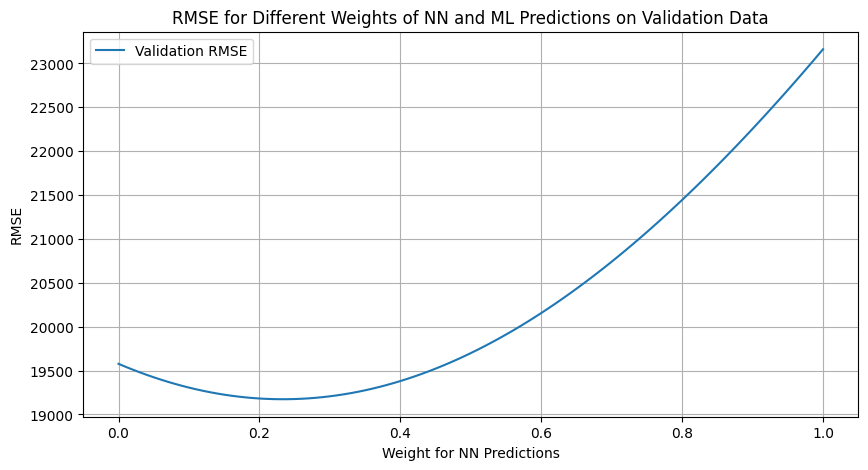

Optimal weight for NN predictions: 0.23
Best RMSE on Validation set: 19173.77361428634
Combined test predictions saved to data/combined_test_predictions.csv
Combined test predictions saved to data/fullml_combined_test_predictions.csv


In [37]:
def load_and_combine_predictions(valid_file_nn, valid_file_ml, test_file_nn, test_file_ml, test_full_file_ml, y_valid):
    # Load data
    nn_valid = pd.read_csv(valid_file_nn)
    ml_valid = pd.read_csv(valid_file_ml)
    nn_test = pd.read_csv(test_file_nn)
    ml_test = pd.read_csv(test_file_ml)
    full_ml_test = pd.read_csv(test_full_file_ml)
    
    # Assuming y_valid is a numpy array containing the actual validation targets
    # y_valid = np.array([...]) # Uncomment this if y_valid needs to be manually input

    # Optimal weights search
    weights = np.linspace(0, 1, 101)  # Creates 101 points from 0 to 1
    rmses = []
    best_rmse = float('inf')
    best_weight = None

    for weight in weights:
        # Combine predictions for validation set
        combined_valid_predictions = weight * nn_valid['Predicted'] + (1 - weight) * ml_valid['Predicted']
        rmse = np.sqrt(mean_squared_error(y_valid, combined_valid_predictions))
        rmses.append(rmse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_weight = weight

    # Plotting RMSE vs. weights
    plt.figure(figsize=(10, 5))
    plt.plot(weights, rmses, label='Validation RMSE')
    plt.xlabel('Weight for NN Predictions')
    plt.ylabel('RMSE')
    plt.title('RMSE for Different Weights of NN and ML Predictions on Validation Data')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'Optimal weight for NN predictions: {best_weight}')
    print(f'Best RMSE on Validation set: {best_rmse}')

    # # Combine test set predictions using optimal weight
    combined_test_predictions = best_weight * nn_test['Predicted'] + (1 - best_weight) * ml_test['Predicted']
    # test_rmse = np.sqrt(mean_squared_error(nn_test['Predicted'], combined_test_predictions))  # Example, replace nn_test['Predicted'] with actual y_test if available

    # # Save combined test predictions
    combined_test_df = pd.DataFrame({
        'Id': nn_test['Id'],
        'Predicted': combined_test_predictions
    })
    combined_test_df.to_csv('data/combined_test_predictions.csv', index=False)
    print("Combined test predictions saved to data/combined_test_predictions.csv")
    # print(f'RMSE on Test set: {test_rmse}')
    
    fullml_combined_test_predictions = best_weight * nn_test['Predicted'] + (1 - best_weight) * full_ml_test['Predicted']
    # test_rmse = np.sqrt(mean_squared_error(nn_test['Predicted'], combined_test_predictions))  # Example, replace nn_test['Predicted'] with actual y_test if available

    # # Save combined test predictions
    combined_test_df = pd.DataFrame({
        'Id': nn_test['Id'],
        'Predicted': fullml_combined_test_predictions
    })
    combined_test_df.to_csv('data/fullml_combined_test_predictions.csv', index=False)
    print("Combined test predictions saved to data/fullml_combined_test_predictions.csv")

# Example usage
load_and_combine_predictions('data/nn_valid.csv', 'data/ml_valid.csv', 'data/nn_test.csv', 'data/ml_test.csv', 'data/full_ml_test.csv',  y_valid)


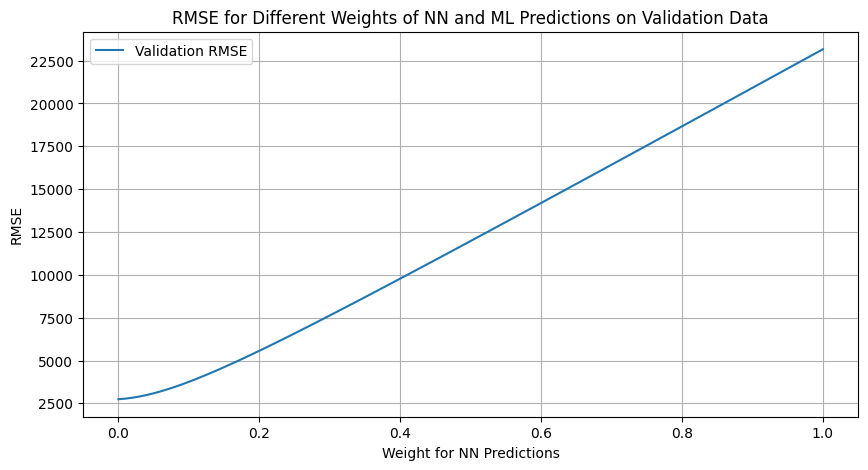

Optimal weight for NN predictions: 0.0
Best RMSE on Validation set: 2741.369320742461


In [38]:
def load_and_combine_predictions(valid_file_nn, valid_file_ml, test_file_nn, test_file_ml, test_full_file_ml, valid_full_file_ml, y_valid):
    # Load data
    nn_valid = pd.read_csv(valid_file_nn)
    ml_valid = pd.read_csv(valid_file_ml)
    nn_test = pd.read_csv(test_file_nn)
    ml_test = pd.read_csv(test_file_ml)
    full_ml_valid = pd.read_csv(valid_full_file_ml)
    full_ml_test = pd.read_csv(test_full_file_ml)
    
    # Assuming y_valid is a numpy array containing the actual validation targets
    # y_valid = np.array([...]) # Uncomment this if y_valid needs to be manually input

    # Optimal weights search
    weights = np.linspace(0, 1, 101)  # Creates 101 points from 0 to 1
    rmses = []
    best_rmse = float('inf')
    best_weight = None

    for weight in weights:
        # Combine predictions for validation set
        combined_valid_predictions = weight * nn_valid['Predicted'] + (1 - weight) * full_ml_valid['Predicted']
        rmse = np.sqrt(mean_squared_error(y_valid, combined_valid_predictions))
        rmses.append(rmse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_weight = weight

    # Plotting RMSE vs. weights
    plt.figure(figsize=(10, 5))
    plt.plot(weights, rmses, label='Validation RMSE')
    plt.xlabel('Weight for NN Predictions')
    plt.ylabel('RMSE')
    plt.title('RMSE for Different Weights of NN and ML Predictions on Validation Data')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'Optimal weight for NN predictions: {best_weight}')
    print(f'Best RMSE on Validation set: {best_rmse}')

    # # Combine test set predictions using optimal weight
    combined_test_predictions = best_weight * nn_test['Predicted'] + (1 - best_weight) * ml_test['Predicted']
    # test_rmse = np.sqrt(mean_squared_error(nn_test['Predicted'], combined_test_predictions))  # Example, replace nn_test['Predicted'] with actual y_test if available

    # # Save combined test predictions
    # combined_test_df = pd.DataFrame({
    #     'Id': nn_test['Id'],
    #     'Predicted': combined_test_predictions
    # })
    # # combined_test_df.to_csv('data/combined_test_predictions.csv', index=False)
    # print("Combined test predictions saved to data/combined_test_predictions.csv")
    # # print(f'RMSE on Test set: {test_rmse}')
    
    # fullml_combined_test_predictions = best_weight * nn_test['Predicted'] + (1 - best_weight) * full_ml_test['Predicted']
    # # test_rmse = np.sqrt(mean_squared_error(nn_test['Predicted'], combined_test_predictions))  # Example, replace nn_test['Predicted'] with actual y_test if available

    # # # Save combined test predictions
    # combined_test_df = pd.DataFrame({
    #     'Id': nn_test['Id'],
    #     'Predicted': fullml_combined_test_predictions
    # })
    # combined_test_df.to_csv('data/fullml_combined_test_predictions.csv', index=False)
    # print("Combined test predictions saved to data/fullml_combined_test_predictions.csv")

# Example usage
load_and_combine_predictions('data/nn_valid.csv', 'data/ml_valid.csv', 'data/nn_test.csv', 'data/ml_test.csv', 'data/full_ml_test.csv', 'data/full_ml_valid.csv',  y_valid)
